Iteration   1: Best signal = 2.402779 at [1.8906186957807647, 0.8815729492607605]
Iteration   2: Best signal = 2.402779 at [1.8906186957807647, 0.8815729492607605]
Iteration   3: Best signal = 2.725060 at [1.9703850107635918, 1.044187911144766]
Iteration   4: Best signal = 2.725060 at [1.9703850107635918, 1.044187911144766]
Iteration   5: Best signal = 2.743452 at [1.9896857236290684, 1.0454265731978456]
Iteration   6: Best signal = 2.752221 at [1.9662943241430817, 0.9777443073888223]
Iteration   7: Best signal = 2.752221 at [1.9662943241430817, 0.9777443073888223]
Iteration   8: Best signal = 2.767483 at [2.021270194110869, 1.0298508305835623]
Iteration   9: Best signal = 2.767483 at [2.021270194110869, 1.0298508305835623]
Iteration  10: Best signal = 2.767483 at [2.021270194110869, 1.0298508305835623]
Iteration  15: Best signal = 2.834527 at [1.9953608552132835, 0.984266637881562]
Iteration  30: Best signal = 2.896461 at [2.0005146338458926, 0.9990825672167027]
Iteration  45: Best si

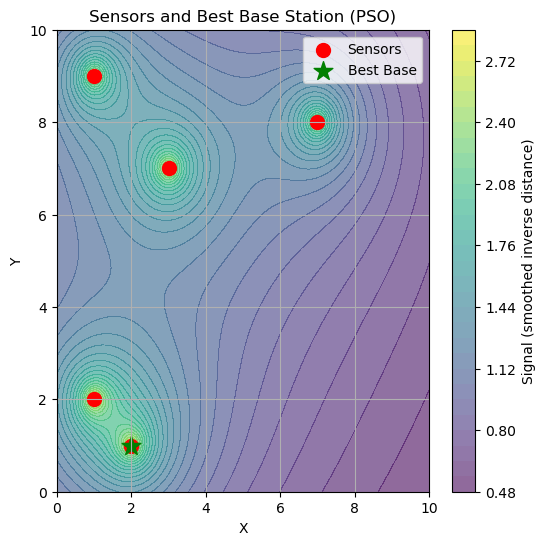

In [7]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt

# ---------- Sensor Nodes ----------
sensors = [(1, 9), (3, 7), (1, 2), (7, 8), (2, 1)]

# ---------- Fitness: maximize sum of inverse distances ----------
# use a small smoothing constant d0 to avoid singularities at sensor locations
D0 = 0.5
def total_signal_strength(pos):
    x, y = pos
    s = 0.0
    for sx, sy in sensors:
        dist = math.hypot(x - sx, y - sy)
        s += 1.0 / (dist + D0)   # smoothed inverse-distance
    return s

# ---------- Particle ----------
class Particle:
    def __init__(self, bounds, vel_max):
        self.bounds = bounds  # (min, max)
        self.position = [random.uniform(bounds[0], bounds[1]),
                         random.uniform(bounds[0], bounds[1])]
        self.velocity = [random.uniform(-vel_max, vel_max),
                         random.uniform(-vel_max, vel_max)]
        self.best_position = list(self.position)
        self.best_value = total_signal_strength(self.position)

    def update_velocity(self, global_best, w=0.7, c1=1.5, c2=1.5, vel_max=None):
        for i in range(2):
            r1, r2 = random.random(), random.random()
            cognitive = c1 * r1 * (self.best_position[i] - self.position[i])
            social = c2 * r2 * (global_best[i] - self.position[i])
            self.velocity[i] = w * self.velocity[i] + cognitive + social
            # clamp velocity
            if vel_max is not None:
                self.velocity[i] = max(-vel_max, min(self.velocity[i], vel_max))

    def update_position(self):
        for i in range(2):
            self.position[i] += self.velocity[i]
            # clamp to bounds
            self.position[i] = max(self.bounds[0], min(self.position[i], self.bounds[1]))
        # evaluate
        val = total_signal_strength(self.position)
        if val > self.best_value:
            self.best_value = val
            self.best_position = list(self.position)

# ---------- PSO ----------
def PSO(num_particles=40, iterations=120, bounds=(0,10), seed=42):
    random.seed(seed)
    np.random.seed(seed)
    span = bounds[1] - bounds[0]
    vel_max = span * 0.2  # reasonable max speed

    swarm = [Particle(bounds, vel_max) for _ in range(num_particles)]

    # initialize global best (maximize fitness)
    global_best = swarm[0].best_position[:]
    global_best_value = swarm[0].best_value
    for p in swarm:
        if p.best_value > global_best_value:
            global_best_value = p.best_value
            global_best = p.best_position[:]

    # main loop
    for it in range(1, iterations + 1):
        for p in swarm:
            p.update_velocity(global_best, w=0.7, c1=1.5, c2=1.5, vel_max=vel_max)
            p.update_position()
            if p.best_value > global_best_value:
                global_best_value = p.best_value
                global_best = p.best_position[:]
        if it % max(1, iterations // 10) == 0 or it <= 10:
            print(f"Iteration {it:3d}: Best signal = {global_best_value:.6f} at {global_best}")
    return global_best, global_best_value

# ---------- Run and plot ----------
if __name__ == "__main__":
    best_pos, best_val = PSO(num_particles=50, iterations=150, bounds=(0,10), seed=123)
    print("\nFinal best position:", best_pos)
    print("Final best total signal:", best_val)

    # plot sensors and best point
    sensor_x, sensor_y = zip(*sensors)
    fig, ax = plt.subplots(figsize=(6,6))

    # optional: background fitness heatmap for visualization
    grid_N = 100
    xs = np.linspace(0, 10, grid_N)
    ys = np.linspace(0, 10, grid_N)
    Z = np.zeros((grid_N, grid_N))
    for i, xx in enumerate(xs):
        for j, yy in enumerate(ys):
            Z[j, i] = sum(1.0 / (math.hypot(xx - sx, yy - sy) + D0) for sx, sy in sensors)

    # show contour/heatmap
    im = ax.contourf(xs, ys, Z, levels=30, alpha=0.6)
    fig.colorbar(im, ax=ax, label='Signal (smoothed inverse distance)')

    ax.scatter(sensor_x, sensor_y, c='red', s=100, label='Sensors')
    ax.scatter([best_pos[0]], [best_pos[1]], c='green', marker='*', s=200, label='Best Base')
    ax.set_xlim(0,10); ax.set_ylim(0,10)
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_title('Sensors and Best Base Station (PSO)')
    ax.grid(True); ax.legend()
    plt.show()
